In [69]:
import torch
from torch import nn
from torchsummary import summary

act_fn = nn.Mish
num_input_channels = 2
base_channel_size = 32
latent_dim = 128

inputs = torch.randn(1, num_input_channels, 256, 1292)
model = nn.Sequential(
    nn.Conv2d(
        in_channels=num_input_channels,
        out_channels=base_channel_size * 2,
        kernel_size=(3, 3),
        padding=(1, 3),
        stride=(2, 2),
    ),
    # nn.LayerNorm([base_channel_size * 2, self.input_shape[1] // 2**1, self.input_shape[2] // 2**1]),
    # torchvision.ops.drop_block.DropBlock2d(p=0.3, block_size=5),
    act_fn(),
    nn.Conv2d(
        in_channels=base_channel_size * 2,
        out_channels=base_channel_size * 2,
        kernel_size=(3, 5),
        padding=(1, 1),
        stride=(2, 3),
    ),
    # nn.LayerNorm([base_channel_size * 2, self.input_shape[1] // 2**2, self.input_shape[2] // (2**2 + 2)]),
    act_fn(),
    nn.Conv2d(
        in_channels=base_channel_size * 2,
        out_channels=base_channel_size * 2,
        kernel_size=(3, 5),
        padding=(1, 1),
        stride=(2, 3),
    ),
    # nn.LayerNorm([base_channel_size * 2, self.input_shape[1] // 2**3, self.input_shape[2] // (2**4 + 2)]),
    act_fn(),
    nn.Conv2d(
        in_channels=base_channel_size * 2,
        out_channels=base_channel_size * 2,
        kernel_size=(3, 5),
        padding=(1, 1),
        stride=(2, 4),
    ),
    act_fn(),
    nn.Flatten(),
    nn.Linear(in_features=576 * base_channel_size, out_features=latent_dim),
    nn.Linear(in_features=latent_dim, out_features=base_channel_size * 576),
    act_fn(),
    nn.Unflatten(dim=1, unflattened_size=(base_channel_size * 2, 16, 18)),
    nn.ConvTranspose2d(
        in_channels=base_channel_size * 2,
        out_channels=base_channel_size * 2,
        kernel_size=(3, 5),
        padding=(1, 1),
        stride=(2, 4),
        output_padding=(1, 1),
    ),
    nn.ConvTranspose2d(
        in_channels=base_channel_size * 2,
        out_channels=base_channel_size * 2,
        kernel_size=(3, 5),
        padding=(1, 1),
        stride=(2, 3),
        output_padding=(1, 0),
    ),
    nn.ConvTranspose2d(
        in_channels=base_channel_size * 2,
        out_channels=base_channel_size * 2,
        kernel_size=(3, 5),
        padding=(1, 1),
        stride=(2, 3),
        output_padding=(1, 0),
    ),
    nn.ConvTranspose2d(
        in_channels=base_channel_size * 2,
        out_channels=num_input_channels,
        kernel_size=(3, 3),
        padding=(1, 3),
        stride=(2, 2),
        output_padding=(1, 1),
    ),
)


summary(model, inputs.shape[1:])

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 648]        1,216
├─Mish: 1-2                              [-1, 64, 128, 648]        --
├─Conv2d: 1-3                            [-1, 64, 64, 216]         61,504
├─Mish: 1-4                              [-1, 64, 64, 216]         --
├─Conv2d: 1-5                            [-1, 64, 32, 72]          61,504
├─Mish: 1-6                              [-1, 64, 32, 72]          --
├─Conv2d: 1-7                            [-1, 64, 16, 18]          61,504
├─Mish: 1-8                              [-1, 64, 16, 18]          --
├─Flatten: 1-9                           [-1, 18432]               --
├─Linear: 1-10                           [-1, 128]                 2,359,424
├─Linear: 1-11                           [-1, 18432]               2,377,728
├─Mish: 1-12                             [-1, 18432]               --
├─Unflatten: 1-13                        [-1, 64, 16, 18

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 648]        1,216
├─Mish: 1-2                              [-1, 64, 128, 648]        --
├─Conv2d: 1-3                            [-1, 64, 64, 216]         61,504
├─Mish: 1-4                              [-1, 64, 64, 216]         --
├─Conv2d: 1-5                            [-1, 64, 32, 72]          61,504
├─Mish: 1-6                              [-1, 64, 32, 72]          --
├─Conv2d: 1-7                            [-1, 64, 16, 18]          61,504
├─Mish: 1-8                              [-1, 64, 16, 18]          --
├─Flatten: 1-9                           [-1, 18432]               --
├─Linear: 1-10                           [-1, 128]                 2,359,424
├─Linear: 1-11                           [-1, 18432]               2,377,728
├─Mish: 1-12                             [-1, 18432]               --
├─Unflatten: 1-13                        [-1, 64, 16, 18

In [145]:
from src.model.dataset.transforms import MinMaxNorm, AddGaussianNoise
import random
from copy import deepcopy
from typing import Self

import numpy as np
import torch
import torchaudio.transforms as T
from safetensors import safe_open
from torch import nn
from torch_audiomentations import OneOf
from torchvision.transforms import v2
import pathlib
from torch.utils.data import DataLoader

paths = pathlib.Path("/home/paolo/git/spotify-playlist-generator/data/raw/tensor_songs/2020/01/17").rglob("*.safetensors")


class AudioDataset(torch.utils.data.Dataset):
    """Dataset class for audio data.

    Args:
        data_path: The path to the audio data.
        crop_size: The size of the cropped audio in seconds.
        mode: The mode of the dataset, either "train", "valid", or "test". Defaults to "train".
    """

    def __init__(
            self: Self,
            data_path: np.ndarray | list[str],
            crop_size: int,
            precision: int,
            mel_spectrogram_param: dict[str, int],
            mode: str = "train",
    ) -> None:
        """Initializes the AudioDataset with the specified parameters.

        Args:
            data_path: The path to the audio data.
            crop_size: The size of the cropped audio in seconds.
            mode: The mode of the dataset, either "train", "valid", or "test". Defaults to "train".
        """
        assert mode in {"train", "valid", "test"}
        super().__init__()
        self.data_path: np.ndarray | list[str] = data_path
        self.crop_size: int = crop_size
        self.mode: str = mode
        self.mel_spectrogram_param: dict[str, int] = mel_spectrogram_param
        self.precision: torch.dtype = {
            16: torch.float16,
            32: torch.float32,
            64: torch.float64,
        }.get(precision)
        self.sample_rate: int = 44100


    def _init_transforms(self: Self, sample_rate: int) -> tuple[v2.Compose, v2.Compose]:
        transforms: list[nn.Module] = [
            T.Resample(orig_freq=sample_rate, new_freq=self.sample_rate),
            T.MelSpectrogram(
                sample_rate=self.sample_rate,
                n_fft=self.mel_spectrogram_param.get("N_FFT", 2048),
                # win_length=self.mel_spectrogram_param.get("WIN_LENGTH", 1024),
                hop_length=self.mel_spectrogram_param.get("HOP_LENGTH", 512),
                n_mels=self.mel_spectrogram_param.get("N_MELS", 256),
                normalized=False,
                power=2,
            ),
            T.AmplitudeToDB(top_db=80.0),
            # ZScoreNorm(),
            MinMaxNorm(min_value=-1.0, max_value=1.0),
            v2.ToDtype(self.precision, scale=False),
        ]

        
        # self.y_transforms = v2.Compose(transforms)
        train_transforms = deepcopy(transforms)
        if self.mode == "train":
            train_transforms.insert(
                2, OneOf([T.TimeMasking(time_mask_param=100), T.FrequencyMasking(freq_mask_param=30)])
            )
            # train_transforms.insert(2, AddGaussianNoise(p=1.0))
            
        # self.x_transforms = v2.Compose(train_transforms)
        return v2.Compose(train_transforms), v2.Compose(transforms)

    def __len__(self: Self) -> int:
        """Returns the length of the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.data_path)

    def add_noise(self, tensor: torch.Tensor) -> torch.Tensor:
        if self.mode != "train":
            return tensor
        noise = torch.randn_like(tensor)
        snr = torch.tensor((50,50))
        return T.AddNoise()(tensor, noise, snr)


    def __getitem__(self: Self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Retrieves the item at the specified index from the dataset.

        Args:
            index (int): The index of the item to retrieve.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: A tuple containing the input and target tensors.
        """
        # print(self.data_path[index])
        with safe_open(self.data_path[index], framework="pt", device="cpu") as f:
            audio: torch.Tensor = f.get_tensor("audio")
            sample_rate: int = f.get_tensor("sample_rate").item()

        print(sample_rate)
        x_transforms, y_transforms = self._init_transforms(sample_rate)

        
        num_frames: int = audio.shape[1]
        crop_frames: int = self.crop_size * self.sample_rate
        # print(f"num_frames: {num_frames}, crop_frames: {crop_frames}, sample_rate: {sample_rate}")
        if num_frames <= crop_frames:
            frames_to_add: int = crop_frames - audio.shape[1]
            audio = torch.cat([audio, torch.zeros((audio.shape[0], frames_to_add))], dim=1)
            print(audio.shape)
            return x_transforms(self.add_noise(audio)), y_transforms(audio)

        x_transformed: torch.Tensor
        y_transformed: torch.Tensor
        while True:
            frame_offset: int = random.randint(0, num_frames - crop_frames)
            cropped_audio = audio[:, frame_offset : frame_offset + crop_frames]
            print(cropped_audio.shape)
            x_transformed, y_transformed = x_transforms(self.add_noise(cropped_audio)), y_transforms(cropped_audio)
            if not torch.isnan(x_transformed).sum() and not torch.isnan(x_transformed).sum():
                break

        print(x_transformed.shape)
        return x_transformed, y_transformed




dataloader = DataLoader(
    dataset=AudioDataset(
        data_path=list(paths),
        mode="train",
        crop_size=30,
        precision=16,
        mel_spectrogram_param={
            "N_FFT": 2048,
            "N_MELS": 256,
            "WIN_LENGTH": 1024,
            "HOP_LENGTH": 1024,
        },
    ),
    batch_size=1,
    num_workers=0,
    shuffle=True,
    pin_memory=True,
    persistent_workers=False,
)

for x, y in dataloader:
    print(x.shape)
    break

48000
torch.Size([2, 1323000])
torch.Size([2, 256, 1188])
torch.Size([1, 2, 256, 1188])


In [146]:
x = torch.randn((2, 1323000))

x = T.Resample(48000, 44100)(x)
print(x.shape)
x = T.MelSpectrogram(
    sample_rate=441000,
    n_fft=2048,
    # win_length=self.mel_spectrogram_param.get("WIN_LENGTH", 1024),
    hop_length=1024,
    n_mels=256,
    normalized=False,
    power=2,
)(x)
x.shape

torch.Size([2, 1215507])


torch.Size([2, 256, 1188])

In [152]:
1188*1024

1216512

In [ ]:
# from IPython.lib.display import Audio
# print(1323000/44100)
# t = torch.zeros((2,1323000))
# Audio(torch.rand_like(t), rate=44100)

In [133]:
import matplotlib.pyplot as plt
def plot_image(x: torch.Tensor, y: torch.Tensor) -> None:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
    img_1 = axs[0].imshow(x.numpy()[0], aspect='auto', cmap='viridis', origin='lower')
    axs[0].set_title("Augmented")
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Frequency Bin')

    img_2 = axs[1].imshow(y.numpy()[0], aspect='auto', cmap='viridis', origin='lower')
    axs[1].set_title("Original")
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Frequency Bin')

    cbar = fig.colorbar(img_2, ax=axs, orientation='vertical', fraction=0.05, pad=0.1)
    cbar.set_label('Db')
    plt.show()

torch.Size([2, 8520795])
torch.Size([2, 1440000])
torch.Size([1, 2, 256, 1407])


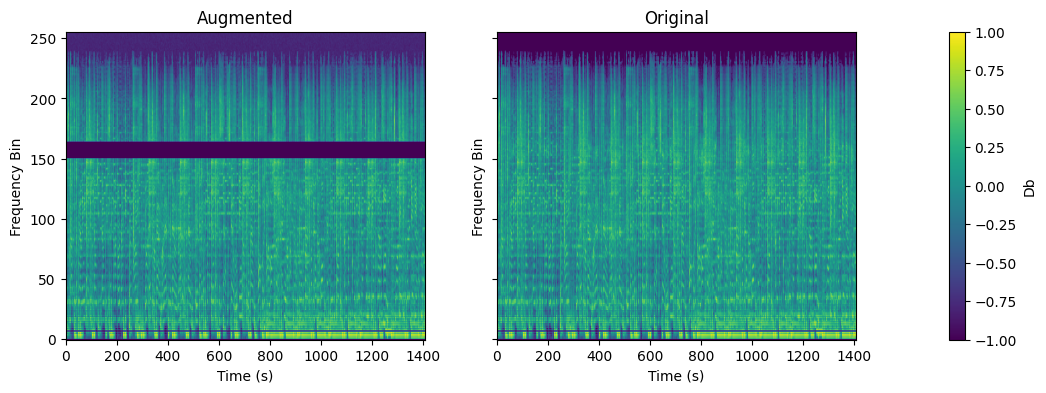

In [134]:
for x, y in dataloader:
    print(x.shape)
    plot_image(x.squeeze(), y.squeeze())
    break